# FIFA Player Awards 2016/17
## Who voted for who?

Original PDF [from FIFA website](http://resources.fifa.com/mm/document/ballon-dor/playeroftheyear-men/02/86/27/05/faward_menplayer2016_neutral.pdf)

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("player_votes.csv")
df.columns = ["voter_type", "country", "voter_name", "vote_first", "vote_second", "vote_third"]
df.head()

,voter_type,country,voter_name,vote_first,vote_second,vote_third
0,Captain,Albania,Agolli Ansi,Cristiano Ronaldo,Messi Lionel,Griezmann Antoine
1,Captain,American Samoa,Ott Ramin,Neymar,Cristiano Ronaldo,Messi Lionel
2,Captain,Andorra,Lima Ildefons,Messi Lionel,Neymar,Cristiano Ronaldo
3,Captain,Angola,Cardoso Dario,Cristiano Ronaldo,Messi Lionel,Sánchez Alexis
4,Captain,Antigua and Barbuda,Joshua Parker,Iniesta Andrés,Cristiano Ronaldo,Neymar


Figure out number of points per player

In [3]:
first_positions = df["vote_first"].value_counts().to_frame()
first_positions["points"] = first_positions["vote_first"] * 5
first_positions = first_positions.reset_index().rename(columns={"index": "player"})
first_positions = first_positions[["player", "points"]]

second_positions = df["vote_second"].value_counts().to_frame()
second_positions["points"] = second_positions["vote_second"] * 3
second_positions = second_positions.reset_index().rename(columns={"index": "player"})
second_positions = second_positions[["player", "points"]]

third_positions = df["vote_third"].value_counts().to_frame()
third_positions = third_positions.reset_index().rename(columns={"index": "player", "vote_third": "points"})
third_positions = third_positions[["player", "points"]]

Aggregate and select Top N players to plot

In [4]:
scores = pd.concat([first_positions, second_positions, third_positions])
scores = scores.groupby("player")["points"].sum().reset_index().sort_values("points", ascending=False)

top_players = scores.iloc[0:5,:]
top_players

,player,points
3,Cristiano Ronaldo,1488
12,Messi Lionel,1061
5,Griezmann Antoine,333
15,Neymar,227
19,Suárez Luis,156


Reverse some names

In [5]:
def reverse_name(name):
    if "Ronaldo" in name or name == "Neymar":
        return name
    return " ".join(reversed(name.split(" ")))

top_players["player"] = top_players["player"].apply(reverse_name)
top_players

,player,points
3,Cristiano Ronaldo,1488
12,Lionel Messi,1061
5,Antoine Griezmann,333
15,Neymar,227
19,Luis Suárez,156


Plot a bar chart of the top players

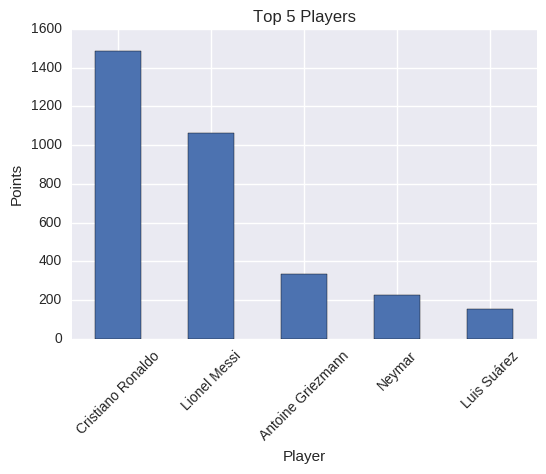

In [6]:
top_players.plot(x="player", y="points", kind="bar", legend=None)
plt.title("Top 5 Players")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.ylabel("Points")
plt.show()

Create a DataFrame of country -> vote format

In [7]:
country_votes = df[["country", "voter_type", "vote_first"]].dropna()
country_votes.columns = ["country", "voter_type", "vote"]
# order of importance should be Coach -> Captain -> Media
# so if there are duplicates, keep the first one of those

# map text values to specific order
country_votes["voter_type"] = country_votes["voter_type"].map({"Coach": 1, "Captain": 2, "Media": 3})

# sort by this specified order
country_votes.sort_values(["country", "voter_type"], inplace=True)
country_votes.drop_duplicates(subset=["country"], keep="first", inplace=True)

# don't care about voter type anymore
country_votes.drop("voter_type", axis=1, inplace=True)

# reverse names here too
country_votes["vote"] = country_votes["vote"].apply(reverse_name)

## Plot choropleth map of votes

First, read in a GeoJSON file (source: [this gist](https://gist.github.com/markmarkoh/2969317) of the World Map as GeoJSON) to get a list of countries and their polygons

In [8]:
import json

with open("countries.json", "r") as f:
    countries = json.loads(f.read())

And sort out the discrepancies between FIFA countries and this list, renaming countries in FIFA list as necessary

In [9]:
geo_countries = []
for c in countries["features"]:
    geo_countries.append(c["properties"]["name"])

country_votes.loc[country_votes["country"] == "American Samoa", "country"] = "Samoa"
country_votes.loc[country_votes["country"] == "Bahamas", "country"] = "Bahamas, The"
country_votes.loc[country_votes["country"] == "Cape Verde Islands", "country"] = "Cape Verde"
country_votes.loc[country_votes["country"] == "China PR", "country"] = "China"
country_votes.loc[country_votes["country"] == "Congo", "country"] = "Congo, Republic of the"
country_votes.loc[country_votes["country"] == "Congo DR", "country"] = "Congo, Democratic Republic of the"
country_votes.loc[country_votes["country"] == "Côte d'Ivoire", "country"] = "Cote d'Ivoire"
country_votes.loc[country_votes["country"] == "Equitorial Guinea", "country"] = "Equatorial Guinea"
country_votes.loc[country_votes["country"] == "FYR Macedonia", "country"] = "Macedonia"
country_votes.loc[country_votes["country"] == "Gambia", "country"] = "Gambia, The"
country_votes.loc[country_votes["country"] == "Korea DPR", "country"] = "Korea, North"
country_votes.loc[country_votes["country"] == "Korea Republic", "country"] = "Korea, South"
country_votes.loc[country_votes["country"] == "Republic of Ireland", "country"] = "Ireland"
country_votes.loc[country_votes["country"] == "St. Kitts and Nevis", "country"] = "Saint Kitts and Nevis"
country_votes.loc[country_votes["country"] == "St. Lucia", "country"] = "Saint Lucia"
country_votes.loc[country_votes["country"] == "São Tomé e Príncipe", "country"] = "Sao Tome e Principe"
country_votes.loc[country_votes["country"] == "USA", "country"] = "United States"

# identify the countries that don't immediately map to a GeoJSON country
# not much we can do about them, they don't exist as those entities in our JSON files
# (although we'll deal with the UK separately)
fifa_countries = list(country_votes["country"].unique())
for c in fifa_countries:
    if c not in geo_countries:
        print(c)

Chinese Taipei
Curaçao
England
Kosovo
Myanmar
Northern Ireland
Scotland
Sao Tome e Principe
Tahiti
Wales


Then map each player (+ the "Other" category) to a colour

In [10]:
colours = ["#ef4943", "#7998f3", "#79d312", "#c266ff", "#f3bf79"]

player_colours = {}
for i, p in enumerate(list(top_players["player"])):
    player_colours[p] = colours[i]

Who didn't vote for the Top N?

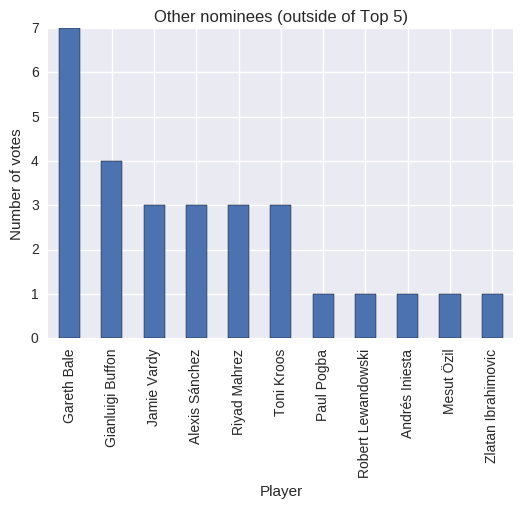

In [11]:
other_countries = country_votes.loc[country_votes["vote"].isin(list(top_players["player"])) == False,
                                    "country"].values

# plot a bar chart for those votes
country_votes.loc[country_votes["country"].isin(other_countries), "vote"].value_counts().plot(kind="bar")
plt.title("Other nominees (outside of Top 5)")
plt.xlabel("Player")
plt.ylabel("Number of votes")
plt.show()

Now bin them into an "Other" or "Unknown" category

In [12]:
# now map the votes to the top N players and an "other" category
def get_player(vote):
    # if the vote is for one of the Top N
    if vote in list(top_players["player"]):
        return vote
    else:
        return "Other"

country_votes["vote"] = country_votes["vote"].apply(lambda x: get_player(x))

Create a dictionary for country -> vote

In [13]:
votes_dict = country_votes.set_index("country")["vote"].to_dict()

What about the UK? Let's see how they voted

In [14]:
country_votes[country_votes["country"].isin(["England", "Scotland", "Wales", "Northern Ireland"])]

,country,vote
203,England,Cristiano Ronaldo
266,Northern Ireland,Cristiano Ronaldo
288,Scotland,Lionel Messi
319,Wales,Other


We'll give that one to Ronaldo

In [15]:
votes_dict["United Kingdom"] = "Cristiano Ronaldo"

Generate the HTML for the legend

In [16]:
from IPython.display import display, HTML

# start with a div that will always be overlayed,
# with a list inside it
legend = """<div style="max-width: 250px;
position: absolute;
right: 0;
top: 3%;
z-index: 1;
background: white;
padding: 0.4em;
text-align: right;">
<ul style="list-style-type: none; padding: 0;">"""

# add a list item for each player
for p in player_colours:
    legend += "<li style=\"padding: 0.3em 2em; background: {0}; margin-bottom: 2px;\">{1}</li>"\
                .format(player_colours[p], p)

# add "Other" element
other_colour = "#3333ee"
legend += "<li style=\"padding: 0.3em 2em; background: {}; color: #DDDDDD; margin-bottom: 2px;\">Other</li>"\
            .format(other_colour)

# add "Unknown" element
unknown_colour = "#444444"
legend += "<li style=\"padding: 0.3em 2em; background: {}; color: #DDDDDD; margin-bottom: 2px;\">Unknown</li>"\
            .format(unknown_colour)
    
# then close it all off

legend += "</ul></div>"
display(HTML(legend))

Now plot the choropleth

In [17]:
import folium

country_map = folium.Map([0, 0], zoom_start=2)

def get_colour(country):
    # if we have a valid entry for that country
    if country in votes_dict:
        # and the player vote is one of the top N
        vote = votes_dict[country]
        if vote in player_colours:
            return player_colours[vote]
        else:
            # otherwise the vote is "Other"
            return other_colour
    # default to "Unknown"
    return unknown_colour

geo_layer = folium.GeoJson(countries,
                           style_function=lambda feature: {
                               'fillColor': get_colour(feature["properties"]["name"]),
                               'fillOpacity': 0.7,
                               'color': 'black',
                               'weight': 2
                           })

geo_layer.add_to(country_map)
country_map

In [18]:
# export the map as HTML
country_map.save("fifa_awards_map.html")
# hack the legend into the exported html
with open("fifa_awards_map.html", "r") as f:
    all_html = f.read()

all_html = all_html.replace("<body>", "<body>{}".format(legend))

with open("fifa_awards_map.html", "w") as f:
    f.write(all_html)